In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
from projects.ephys.population import Population
import pandas as pd
from src.utils.path import find
from src.utils.auxiliary import flatten_series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

In [2]:
mpl.rcParams.update({'font.size': 26})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [3]:
%matplotlib inline

In [4]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_pop2')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_pop2.pickle


In [5]:
# hffm.add_avalible_RcSn_psth()

reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/062921/G6HCK1ALTRN/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/101521/J559NC/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/102621/J558NC/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110321/J558LT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110421/J569LT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/122021/J581RT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/020222/J577TT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_movi

In [6]:
# hffm.save(fname='hffm_pop2')

saving to /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_pop2.pickle


In [5]:
def movement_psth(panel, row, rightname, legend=False):
    leftname = rightname.replace('right','left')
    panel.plot(hffm.trange_x, row[rightname], color=hffm.cmap_sacc[0], label='right')
    panel.plot(hffm.trange_x, row[leftname], color=hffm.cmap_sacc[1], label='left')
    panel.set_ylim([0, np.max(np.maximum(row[rightname], row[leftname]))*1.2])
    panel.set_xlim([-0.2, 0.4])
    panel.set_ylabel('sp/sec')
    panel.set_xlabel('sec')
    if legend:
        panel.legend(loc=9, ncol=2)

In [6]:
def plot_flow_vec(panel, movstate, row):
    fv = row['FmLt_optic_flow_'+movstate+'_vec'].astype(float) # shape is [x, y, U/V]

    nx = 5
    fv_scale = row['FmLt_flowvec_scale']
    flow_w = np.size(fv, 1)
    flow_h = np.size(fv, 0)

    X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
    U = fv[:,:,0]; V = fv[:,:,1]

    panel.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)
    panel.axis('off')
    panel.axis('equal')

In [7]:
def wrap_tuning(vals):
    vals = vals.flatten()
    return np.hstack([vals, vals[0]])

In [8]:
def modind(a, b):
    """
    value of 1 means a is more significant
    value of -1 means b is more significant
    """
    mi = (a - b) / (a + b)
    return mi

In [9]:
for ind, row in hffm.data[hffm.data['fr']>2].iterrows():
    if row['movcluster'] in ['early','late','biphasic','negative']:
        pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        
        if row['pref_gazeshift_direction']=='L':
            left_gaze = pref_gaze; right_gaze = nonpref_gaze
            left_comp = pref_comp; right_comp = nonpref_comp
        elif row['pref_gazeshift_direction']=='R':
            right_gaze = pref_gaze; left_gaze = nonpref_gaze
            right_comp = pref_comp; left_comp = nonpref_comp
        
        hffm.data.at[ind, 'gaze_sacc_rlMI'] = modind(np.max(right_gaze), np.max(left_gaze))
        hffm.data.at[ind, 'comp_sacc_rlMI'] = modind(np.max(right_comp), np.max(left_comp))
        hffm.data.at[ind, 'gaze_sacc_pnpMI'] = modind(np.max(pref_gaze), np.max(nonpref_gaze))
        hffm.data.at[ind, 'comp_sacc_pnpMI'] = modind(np.max(pref_comp), np.max(nonpref_comp))
        
    if row['responsive_to_gratings']:
        ori = row['Gt_ori_tuning_mean_tf']
        best_sf = ori[:,np.argmax(np.mean(ori,0))]
        left_grat = best_sf[0]
        right_grat = best_sf[4]
        hffm.data.at[ind, 'gratings_rlMI'] = modind(right_grat, left_grat)

In [10]:
def direcpref_scatter_c(panel, xname, yname):
    for i in range(4):
        name = ['early','late','biphasic','negative'][i]
        x_mi = hffm.data[xname][hffm.data['movcluster']==name]
        y_mi = hffm.data[yname][hffm.data['movcluster']==name]
        panel.plot(x_mi, y_mi, '.', color=hffm.cmap_movclusts[i+1], markersize=6)
    panel.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    panel.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')

In [11]:
page = 188
row = hffm.data.iloc[page]

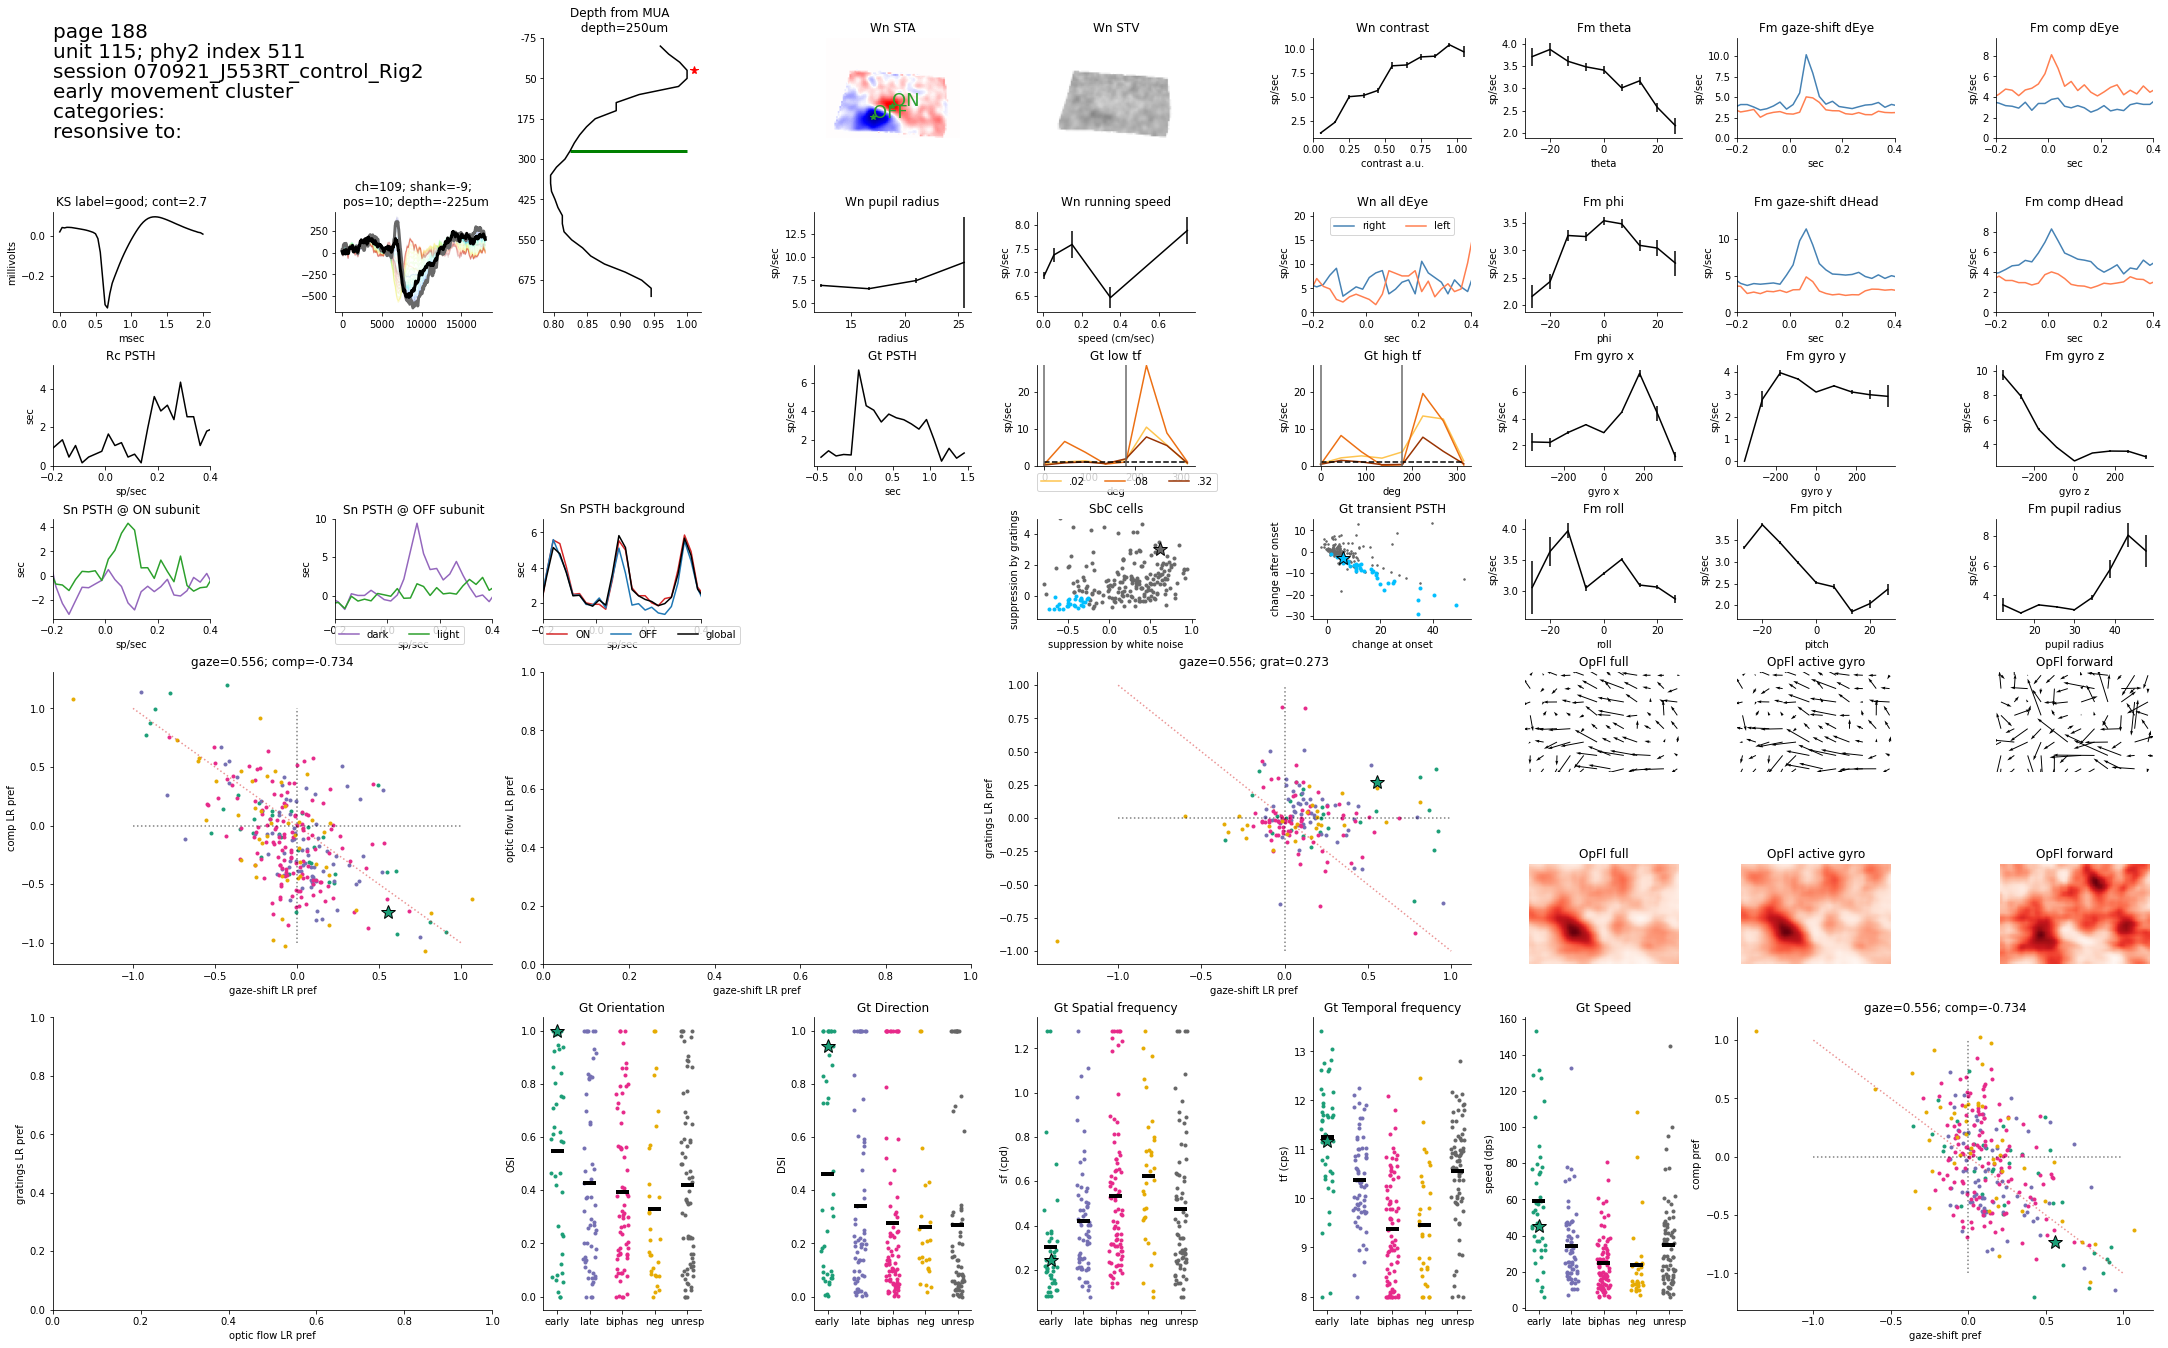

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(30,20))
spec = gridspec.GridSpec(nrows=9, ncols=9, figure=fig)

ax_text = fig.add_subplot(spec[0,0:2])
ax_spwvfrm = fig.add_subplot(spec[1,0])
ax_Rc_depth = fig.add_subplot(spec[1,1])
ax_MUA_depth = fig.add_subplot(spec[0:2,2])

ax_Wn_STA = fig.add_subplot(spec[0,3])
ax_Wn_STV = fig.add_subplot(spec[0,4])
ax_Wn_tuning = fig.add_subplot(spec[0,5])
ax_Wn_pupilrad = fig.add_subplot(spec[1,3])
ax_Wn_speed = fig.add_subplot(spec[1,4])
ax_Wn_sacc = fig.add_subplot(spec[1,5])

ax_Rc_psth = fig.add_subplot(spec[2,0])
ax_Sn_psth_on = fig.add_subplot(spec[3,0])
ax_Sn_psth_off = fig.add_subplot(spec[3,1])
ax_Sn_psth_background = fig.add_subplot(spec[3,2])

ax_Gt_psth = fig.add_subplot(spec[2,3])
ax_Gt_polar_ltf = fig.add_subplot(spec[2,4])
ax_Gt_polar_htf = fig.add_subplot(spec[2,5])

ax_theta = fig.add_subplot(spec[0,6])
ax_phi = fig.add_subplot(spec[1,6])
ax_gyrox = fig.add_subplot(spec[2,6])
ax_gyroy = fig.add_subplot(spec[2,7])
ax_gyroz = fig.add_subplot(spec[2,8])
ax_roll = fig.add_subplot(spec[3,6])
ax_pitch = fig.add_subplot(spec[3,7])
ax_Fm_pupilrad = fig.add_subplot(spec[3,8])
ax_Fm_sacc_gaze_dEye = fig.add_subplot(spec[0,7])
ax_Fm_sacc_comp_dEye = fig.add_subplot(spec[0,8])
ax_Fm_sacc_gaze_dHead = fig.add_subplot(spec[1,7])
ax_Fm_sacc_comp_dHead = fig.add_subplot(spec[1,8])
ax_full_opfl_vec = fig.add_subplot(spec[4,6])
ax_gyro_opfl_vec = fig.add_subplot(spec[4,7])
ax_top_opfl_vec = fig.add_subplot(spec[4,8])
ax_full_opfl_amp = fig.add_subplot(spec[5,6])
ax_gyro_opfl_amp = fig.add_subplot(spec[5,7])
ax_top_opfl_amp = fig.add_subplot(spec[5,8])

ax_SbC = fig.add_subplot(spec[3,4])
ax_tr_grat = fig.add_subplot(spec[3,5])

ax_PNP_gaze_comp = fig.add_subplot(spec[6:8,7:9])
ax_LR_gaze_comp = fig.add_subplot(spec[4:6,0:2])
ax_LR_gaze_opfl = fig.add_subplot(spec[4:6,2:4])
ax_LR_gaze_grat = fig.add_subplot(spec[4:6,4:6])
ax_LR_opfl_grat = fig.add_subplot(spec[6:8,0:2])

ax_osi = fig.add_subplot(spec[6:8,2])
ax_dsi = fig.add_subplot(spec[6:8,3])
ax_sf = fig.add_subplot(spec[6:8,4])
ax_tf = fig.add_subplot(spec[6:8,5])
ax_speed = fig.add_subplot(spec[6:8,6])

cluster_names = ['early','late','biphasic','negative','unresponsive']

ax_text.axis('off')
ind_in_session = int(np.argwhere(hffm.data[hffm.data['session']==row['session']].index.values==page).flatten())
ax_text.annotate('page {}'.format(page), color='k', xy=[0,0], fontsize=20)
ax_text.annotate('unit {}; phy2 index {}'.format(ind_in_session, row['index']), color='k', xy=[0,1], fontsize=20)
ax_text.annotate('session {}'.format(row['session']), color='k', xy=[0,2], fontsize=20)
ax_text.annotate('{} movement cluster'.format(row['movcluster']), color='k', xy=[0,3], fontsize=20)
otherprops = []; responsive_to = []
if row['is_SbC']:
    otherprops.append('Wn SbC')
if row['is_grat_trpsth']:
    otherprops.append('Gt transient ')
if row['responsive_to_gratings']:
    responsive_to.append('Gt')
if row['responsive_to_contrast']:
    responsive_to.append('Wn')
ax_text.annotate('categories: '.format(otherprops), color='k', xy=[0,4], fontsize=20)
ax_text.annotate('resonsive to: '.format(responsive_to), color='k', xy=[0,5], fontsize=20)
ax_text.set_ylim([5,0])

ax_spwvfrm.plot(np.arange(len(row['waveform']))*1000/hffm.samprate, row['waveform'], color='k')
ax_spwvfrm.set_ylabel('millivolts'); ax_spwvfrm.set_xlabel('msec')
ax_spwvfrm.set_title('KS label={}; cont={:3}'.format(row['KSLabel'], row['ContamPct']))

cmap_Rc_depth = plt.cm.jet(np.linspace(0,1,32))
shank_num = int(np.floor(int(row['ch'])/32))
shank_channels = [c for c in range(np.size(row['Rc_response_by_channel'], 0)) if int(np.floor(c/32)) == int(np.floor(int(row['ch'])/32))]
whole_shank = row['Rc_response_by_channel'][shank_channels]
for ch_num in range(len(shank_channels)):
    ax_Rc_depth.plot(whole_shank[ch_num], color=cmap_Rc_depth[ch_num], alpha=0.1, linewidth=1) # all other channels
ax_Rc_depth.plot(whole_shank[row['Rc_layer4cent'][shank_num]], color='dimgray', label='layer4', linewidth=3) # layer 4
ax_Rc_depth.plot(row['Rc_response_by_channel'][row['ch']%32], color='k', label='this channel', linewidth=3)
ax_Rc_depth.set_title('ch={}; shank={};\n pos={}; depth={}um'.format(row['ch'], int(row['Rc_relative_depth'][1][row['ch']-([0, 32, 64, 96][shank_num])]), int(row['Rc_relative_depth'][shank_num][row['ch']%32]), int(row['Rc_depth_from_layer4'])))

ax_MUA_depth.hlines(y=row['ch']%32, xmin=row['Wn_lfp_power'][shank_num][int(row['ch']%32)], xmax=1, colors='g', linewidth=3)
ax_MUA_depth.set_ylim([33,-1])
ax_MUA_depth.set_yticks(list(range(-1,32+1,5)))
ax_MUA_depth.set_yticklabels(25*np.arange(0,32+2,5)-(row['Wn_layer5cent_from_lfp'][shank_num]*25))
ax_MUA_depth.plot(row['Wn_lfp_power'][shank_num],range(0,32),color='k')
ax_MUA_depth.plot(row['Wn_lfp_power'][shank_num][row['Wn_layer5cent_from_lfp'][shank_num]]+0.01, row['Wn_layer5cent_from_lfp'][shank_num],'r*',markersize=8)
ax_MUA_depth.set_title('Depth from MUA \n depth={:0}um'.format(25*(row['ch']%32)-(row['Wn_layer5cent_from_lfp'][shank_num]*25)))

sta_range = np.max(np.abs(row['Wn_spike_triggered_average']))*1.2
sta_range = (0.25 if sta_range<0.25 else sta_range)
ax_Wn_STA.imshow(row['Wn_spike_triggered_average'], vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_Wn_STA.set_title('Wn STA')
ax_Wn_STA.axis('off')
ax_Wn_STA.plot(row['Wn_rf_on_cent'][0], row['Wn_rf_on_cent'][1], '*', color='tab:green')
ax_Wn_STA.annotate('ON', xy=[row['Wn_rf_on_cent'][0], row['Wn_rf_on_cent'][1]], color='tab:green', fontsize=18)
ax_Wn_STA.plot(row['Wn_rf_off_cent'][0], row['Wn_rf_off_cent'][1], '*', color='tab:green')
ax_Wn_STA.annotate('OFF', xy=[row['Wn_rf_off_cent'][0], row['Wn_rf_off_cent'][1]], color='tab:green', fontsize=18)

# sta_range = np.max(np.abs(row['Wn_spike_triggered_variance']))*1.2
# sta_range = (0.25 if sta_range<0.25 else sta_range)
ax_Wn_STV.imshow(row['Wn_spike_triggered_variance'], vmin=0, vmax=1, cmap='binary')
ax_Wn_STV.set_title('Wn STV')
ax_Wn_STV.axis('off')

ax_Wn_tuning.set_title('Wn contrast')
ax_Wn_tuning.errorbar(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], yerr=row['Wn_contrast_tuning_err'], color='k')
ax_Wn_tuning.set_ylabel('sp/sec')
ax_Wn_tuning.set_xlabel('contrast a.u.')

ax_Wn_pupilrad.set_title('Wn pupil radius')
ax_Wn_pupilrad.errorbar(row['Wn_pupilradius_tuning_bins'], row['Wn_pupilradius_tuning'], yerr=row['Wn_pupilradius_tuning_err'], color='k')
ax_Wn_pupilrad.set_ylabel('sp/sec')
ax_Wn_pupilrad.set_xlabel('radius')

ax_Wn_speed.set_title('Wn running speed')
ax_Wn_speed.errorbar(row['Wn_ballspeed_tuning_bins'], row['Wn_ballspeed_tuning'], yerr=row['Wn_ballspeed_tuning_err'], color='k')
ax_Wn_speed.set_ylabel('sp/sec')
ax_Wn_speed.set_xlabel('speed (cm/sec)')

movement_psth(ax_Wn_sacc, row, 'Wn_rightsacc_avg', legend=True)
ax_Wn_sacc.set_title('Wn all dEye')

ax_Rc_psth.plot(hffm.trange_x, row['Rc_psth'], color='k')
ax_Rc_psth.set_ylim([0,np.nanmax(row['Rc_psth'])*1.2])
ax_Rc_psth.set_title('Rc PSTH')
ax_Rc_psth.set_ylabel('sec')
ax_Rc_psth.set_xlabel('sp/sec')
ax_Rc_psth.set_xlim([-0.2,0.4])

ax_Sn_psth_on.plot(hffm.trange_x, row['Sn_on_darkstim_psth'] - row['Sn_on_background_psth'], color='tab:purple', label='dark')
ax_Sn_psth_on.plot(hffm.trange_x, row['Sn_on_lightstim_psth'] - row['Sn_on_background_psth'], color='tab:green', label='light')
ax_Sn_psth_on.set_title('Sn PSTH @ ON subunit')
ax_Sn_psth_on.set_ylabel('sec')
ax_Sn_psth_on.set_xlabel('sp/sec')
ax_Sn_psth_on.set_xlim([-0.2,0.4])

ax_Sn_psth_off.plot(hffm.trange_x, row['Sn_off_darkstim_psth'] - row['Sn_off_background_psth'], color='tab:purple', label='dark')
ax_Sn_psth_off.plot(hffm.trange_x, row['Sn_off_lightstim_psth'] - row['Sn_off_background_psth'], color='tab:green', label='light')
ax_Sn_psth_off.set_title('Sn PSTH @ OFF subunit')
ax_Sn_psth_off.set_ylabel('sec')
ax_Sn_psth_off.set_xlabel('sp/sec')
ax_Sn_psth_off.set_xlim([-0.2,0.4])
ax_Sn_psth_off.legend(ncol=2, loc=(0,-.25))

ax_Sn_psth_background.plot(hffm.trange_x, row['Sn_on_background_psth'], color='tab:red', label='ON')
ax_Sn_psth_background.plot(hffm.trange_x, row['Sn_off_background_psth'], color='tab:blue', label='OFF')
ax_Sn_psth_background.plot(hffm.trange_x, row['Sn_on_all_psth'], color='k', label='global')
ax_Sn_psth_background.set_title('Sn PSTH background')
ax_Sn_psth_background.set_ylabel('sec')
ax_Sn_psth_background.set_xlabel('sp/sec')
ax_Sn_psth_background.set_xlim([-0.2,0.4])
ax_Sn_psth_background.legend(ncol=3, loc=(0,-.25))
    
ax_Gt_psth.plot(hffm.grat_psth_x, row['Gt_grating_psth'], 'k')
ax_Gt_psth.set_title('Gt PSTH')
ax_Gt_psth.set_ylabel('sp/sec')
ax_Gt_psth.set_xlabel('sec')

for tf, panel in enumerate([ax_Gt_polar_ltf, ax_Gt_polar_htf]):
    for sf, label in enumerate(['.02','.08','.32']):
        panel.plot(np.arange(8)*45, row['Gt_ori_tuning_tf'][:,sf,tf], color=hffm.cmap_orientation[sf], label=label)
    panel.plot(np.arange(8)*45, np.ones(8)*row['Gt_drift_spont'], linestyle='dashed', color=hffm.cmap_orientation[3])
    panel.set_ylabel('sp/sec')
    panel.set_xlabel('deg')
    maxval = np.max(np.hstack([row['Gt_ori_tuning_tf'].flatten(), row['Gt_drift_spont']]))
    panel.vlines(0, 0, maxval, 'dimgray'); panel.vlines(180, 0, maxval, 'dimgray')
    panel.set_ylim([0,maxval])

ax_Gt_polar_ltf.set_title('Gt low tf')
ax_Gt_polar_ltf.legend(ncol=3, loc=(0,-.25))

ax_Gt_polar_htf.set_title('Gt high tf')

ax_theta.set_title('Fm theta')
ax_theta.errorbar(row['FmLt_theta_tuning_bins'], row['FmLt_theta_tuning'], yerr=row['FmLt_theta_tuning_err'], color='k')
ax_theta.set_ylabel('sp/sec')
ax_theta.set_xlabel('theta')

ax_phi.set_title('Fm phi')
ax_phi.errorbar(row['FmLt_phi_tuning_bins'], row['FmLt_phi_tuning'], yerr=row['FmLt_phi_tuning_err'], color='k')
ax_phi.set_ylabel('sp/sec')
ax_phi.set_xlabel('phi')

ax_gyrox.set_title('Fm gyro x')
ax_gyrox.errorbar(row['FmLt_gyrox_tuning_bins'], row['FmLt_gyrox_tuning'], yerr=row['FmLt_gyrox_tuning_err'], color='k')
ax_gyrox.set_ylabel('sp/sec')
ax_gyrox.set_xlabel('gyro x')

ax_gyroy.set_title('Fm gyro y')
ax_gyroy.errorbar(row['FmLt_gyroy_tuning_bins'], row['FmLt_gyroy_tuning'], yerr=row['FmLt_gyroy_tuning_err'], color='k')
ax_gyroy.set_ylabel('sp/sec')
ax_gyroy.set_xlabel('gyro y')

ax_gyroz.set_title('Fm gyro z')
ax_gyroz.errorbar(row['FmLt_gyroz_tuning_bins'], row['FmLt_gyroz_tuning'], yerr=row['FmLt_gyroz_tuning_err'], color='k')
ax_gyroz.set_ylabel('sp/sec')
ax_gyroz.set_xlabel('gyro z')

ax_roll.set_title('Fm roll')
ax_roll.errorbar(row['FmLt_roll_tuning_bins'], row['FmLt_roll_tuning'], yerr=row['FmLt_roll_tuning_err'], color='k')
ax_roll.set_ylabel('sp/sec')
ax_roll.set_xlabel('roll')

ax_pitch.set_title('Fm pitch')
ax_pitch.errorbar(row['FmLt_pitch_tuning_bins'], row['FmLt_pitch_tuning'], yerr=row['FmLt_pitch_tuning_err'], color='k')
ax_pitch.set_ylabel('sp/sec')
ax_pitch.set_xlabel('pitch')

ax_Fm_pupilrad.set_title('Fm pupil radius')
ax_Fm_pupilrad.errorbar(row['FmLt_pupilradius_tuning_bins'], row['FmLt_pupilradius_tuning'], yerr=row['FmLt_pupilradius_tuning_err'], color='k')
ax_Fm_pupilrad.set_ylabel('sp/sec')
ax_Fm_pupilrad.set_xlabel('pupil radius')

movement_psth(ax_Fm_sacc_gaze_dEye, row, 'FmLt_rightsacc_avg_gaze_shift_dEye')
ax_Fm_sacc_gaze_dEye.set_title('Fm gaze-shift dEye')

movement_psth(ax_Fm_sacc_comp_dEye, row, 'FmLt_rightsacc_avg_comp_dEye')
ax_Fm_sacc_comp_dEye.set_title('Fm comp dEye')

movement_psth(ax_Fm_sacc_gaze_dHead, row, 'FmLt_rightsacc_avg_gaze_shift_dHead')
ax_Fm_sacc_gaze_dHead.set_title('Fm gaze-shift dHead')

movement_psth(ax_Fm_sacc_comp_dHead, row, 'FmLt_rightsacc_avg_comp_dHead')
ax_Fm_sacc_comp_dHead.set_title('Fm comp dHead')

plot_flow_vec(ax_full_opfl_vec, 'full', row)
ax_full_opfl_vec.set_title('OpFl full')

plot_flow_vec(ax_gyro_opfl_vec, 'active_gyro', row)
ax_gyro_opfl_vec.set_title('OpFl active gyro')

plot_flow_vec(ax_top_opfl_vec, 'running_forward', row)
ax_top_opfl_vec.set_title('OpFl forward')

ax_full_opfl_amp.imshow(row['FmLt_optic_flow_full_amp'].astype(float), cmap='Reds')
ax_full_opfl_amp.axis('off')
ax_full_opfl_amp.axis('equal')
ax_full_opfl_amp.set_title('OpFl full')

ax_gyro_opfl_amp.imshow(row['FmLt_optic_flow_active_gyro_amp'].astype(float), cmap='Reds')
ax_gyro_opfl_amp.axis('off')
ax_gyro_opfl_amp.axis('equal')
ax_gyro_opfl_amp.set_title('OpFl active gyro')

ax_top_opfl_amp.imshow(row['FmLt_optic_flow_running_forward_amp'].astype(float), cmap='Reds')
ax_top_opfl_amp.axis('off')
ax_top_opfl_amp.axis('equal')
ax_top_opfl_amp.set_title('OpFl forward')

SBCs = hffm.data[hffm.data['is_SbC']]
ax_SbC.plot(-hffm.data['SbC_min_mid_mod'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  hffm.data['grat_psth_drop'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  '.', color=hffm.cmap_special2[0], markersize=6)
ax_SbC.plot(-SBCs['SbC_min_mid_mod'], SBCs['grat_psth_drop'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_SbC.plot(-row['SbC_min_mid_mod'], row['grat_psth_drop'], '*',
                color=hffm.cmap_special2[row['is_SbC']], markersize=15, markeredgecolor='k')
ax_SbC.set_ylim([-1.5,5])
ax_SbC.set_title('SbC cells')
ax_SbC.set_ylabel('suppression by gratings')
ax_SbC.set_xlabel('suppression by white noise')

trPsth = hffm.data[hffm.data['is_grat_trpsth']][hffm.data['responsive_to_gratings']]
sPsth = hffm.data[hffm.data['responsive_to_gratings']][hffm.data['is_grat_trpsth']==False]
ax_tr_grat.plot(sPsth['change_at_gratstim_onset'], sPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[0], markersize=3)
ax_tr_grat.plot(trPsth['change_at_gratstim_onset'], trPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_tr_grat.plot(row['change_at_gratstim_onset'], row['change_during_gratstim'], '*',
                color=hffm.cmap_special2[row['is_grat_trpsth']], markersize=15, markeredgecolor='k')
ax_tr_grat.set_ylabel('change after onset')
ax_tr_grat.set_xlabel('change at onset')
ax_tr_grat.set_title('Gt transient PSTH')

direcpref_scatter_c(ax_PNP_gaze_comp, 'gaze_sacc_pnpMI', 'comp_sacc_pnpMI')
ax_PNP_gaze_comp.plot(row['gaze_sacc_pnpMI'], row['comp_sacc_pnpMI'], '*',
                      color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1],
                      markersize=15, markeredgecolor='k')
ax_PNP_gaze_comp.set_ylabel('comp pref')
ax_PNP_gaze_comp.set_xlabel('gaze-shift pref')
ax_PNP_gaze_comp.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
ax_PNP_gaze_comp.set_title('gaze={:.3}; comp={:.3}'.format(row['gaze_sacc_pnpMI'], row['comp_sacc_pnpMI']))

direcpref_scatter_c(ax_LR_gaze_comp, 'gaze_sacc_rlMI', 'comp_sacc_rlMI')
ax_LR_gaze_comp.plot(row['gaze_sacc_rlMI'], row['comp_sacc_rlMI'], '*',
                      color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1],
                      markersize=15, markeredgecolor='k')
ax_LR_gaze_comp.set_ylabel('comp LR pref')
ax_LR_gaze_comp.set_xlabel('gaze-shift LR pref')
ax_LR_gaze_comp.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
ax_LR_gaze_comp.set_title('gaze={:.3}; comp={:.3}'.format(row['gaze_sacc_rlMI'], row['comp_sacc_rlMI']))

direcpref_scatter_c(ax_LR_gaze_grat, 'gaze_sacc_pnpMI', 'gratings_rlMI')
ax_LR_gaze_grat.plot(row['gaze_sacc_rlMI'], row['gratings_rlMI'], '*',
                      color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1],
                      markersize=15, markeredgecolor='k')
ax_LR_gaze_grat.set_ylabel('gratings LR pref')
ax_LR_gaze_grat.set_xlabel('gaze-shift LR pref')
ax_LR_gaze_grat.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
ax_LR_gaze_grat.set_title('gaze={:.3}; grat={:.3}'.format(row['gaze_sacc_rlMI'], row['gratings_rlMI']))

for c, cluster in enumerate(cluster_names):
    data = hffm.data['osi_for_sf_pref'][hffm.data['movcluster']==cluster][hffm.data['responsive_to_gratings']]
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    ax_osi.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[c+1])
    ax_osi.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
#     ax_osi.set_ylim([0,120])
    ax_osi.set_title('Gt Orientation')
    ax_osi.set_ylabel('OSI')
    ax_osi.set_xticks(range(5), ['early','late','biphas','neg','unresp'])
ax_osi.plot(cluster_names.index(row['movcluster']), row['osi_for_sf_pref'], '*',
         color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')
    
for c, cluster in enumerate(cluster_names):
    data = hffm.data['dsi_for_sf_pref'][hffm.data['movcluster']==cluster][hffm.data['responsive_to_gratings']]
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    ax_dsi.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[c+1])
    ax_dsi.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
#     ax_dsi.set_ylim([0,120])
    ax_dsi.set_title('Gt Direction')
    ax_dsi.set_ylabel('DSI')
    ax_dsi.set_xticks(range(5), ['early','late','biphas','neg','unresp'])
ax_dsi.plot(cluster_names.index(row['movcluster']), row['dsi_for_sf_pref'], '*',
         color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')
    
for c, cluster in enumerate(cluster_names):
    data = hffm.data['sf_pref_cpd'][hffm.data['movcluster']==cluster][hffm.data['responsive_to_gratings']]
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    ax_sf.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[c+1])
    ax_sf.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
#     ax_sf.set_ylim([0,120])
    ax_sf.set_title('Gt Spatial frequency')
    ax_sf.set_ylabel('sf (cpd)')
    ax_sf.set_xticks(range(5), ['early','late','biphas','neg','unresp'])
ax_sf.plot(cluster_names.index(row['movcluster']), row['sf_pref_cpd'], '*',
         color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')
    
for c, cluster in enumerate(cluster_names):
    data = hffm.data['tf_pref_cps'][hffm.data['movcluster']==cluster][hffm.data['responsive_to_gratings']]
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    ax_tf.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[c+1])
    ax_tf.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
#     ax_tf.set_ylim([0,120])
    ax_tf.set_title('Gt Temporal frequency')
    ax_tf.set_ylabel('tf (cps)')
    ax_tf.set_xticks(range(5), ['early','late','biphas','neg','unresp'])
ax_tf.plot(cluster_names.index(row['movcluster']), row['tf_pref_cps'], '*',
         color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')
    
for c, cluster in enumerate(cluster_names):
    data = hffm.data['grat_speed_dps'][hffm.data['movcluster']==cluster][hffm.data['responsive_to_gratings']]
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    ax_speed.plot(x_jitter, data, '.', color=hffm.cmap_movclusts[c+1])
    ax_speed.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
#     ax_speed.set_ylim([0,120])
    ax_speed.set_title('Gt Speed')
    ax_speed.set_ylabel('speed (dps)')
    ax_speed.set_xticks(range(5), ['early','late','biphas','neg','unresp'])
ax_speed.plot(cluster_names.index(row['movcluster']), row['grat_speed_dps'], '*',
         color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

ax_LR_gaze_opfl.set_ylabel('optic flow LR pref')
ax_LR_gaze_opfl.set_xlabel('gaze-shift LR pref')

ax_LR_opfl_grat.set_xlabel('optic flow LR pref')
ax_LR_opfl_grat.set_ylabel('gratings LR pref')

# direcpref_scatter_c(ax_LR_gaze_grat, 'gaze_sacc_pnpMI', 'gratings_rlMI')
# ax_LR_gaze_grat.plot(row['gaze_sacc_rlMI'], row['gratings_rlMI'], '*',
#                       color=hffm.cmap_movclusts[cluster_names.index(row['movcluster'])+1],
#                       markersize=15, markeredgecolor='k')
# ax_LR_gaze_grat.set_ylabel('gratings LR pref')
# ax_LR_gaze_grat.set_xlabel('gaze-shift LR pref')
# ax_LR_gaze_grat.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
# ax_PNP_gaze_comp.set_title('gaze={:.3}; grat={:.3}'.format(row['gaze_sacc_rlMI'], row['gratings_rlMI']))

# ax_LR_gaze_opfl = fig.add_subplot(spec[4:6,2:4])
# ax_LR_opfl_grat = fig.add_subplot(spec[6:8,0:2])
# ax_bars = fig.add_subplot(spec[6:8,2:])

fig.savefig('/home/niell_lab/Desktop/unitsummary_page188.pdf')

In [71]:
has_RF = np.array(sorted([2,7,5,11,15,13,12,16,17,21,25,28,29,30,42,45,49,50,53,56,58,63,60,68,69,70,
          71,75,74,73,72,76,77,78,79,80,81,82,83,84,89,90,93,94,100,101,104,108,110,
          114,115,122,120,124,125]))
session_indices = hffm.data['index'][hffm.data['session']=='070921_J553RT_control_Rig2'].to_numpy()

In [74]:
has_RF = range(128)

In [17]:
len(has_RF) / len(session_indices)

1.0

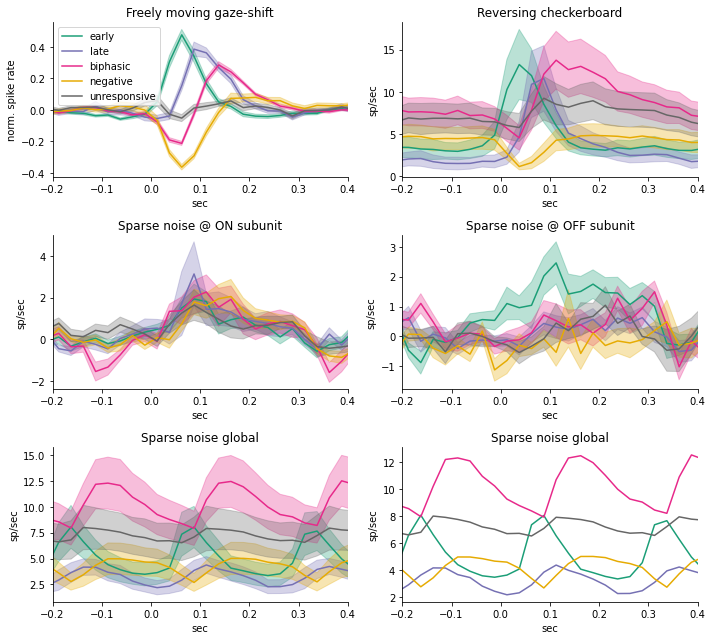

In [19]:
plt.subplots(3,2,figsize=(10,9))
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    cluster_data = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'][hffm.data['movcluster']==name]
    
    plt.subplot(321)
    plt.title('Freely moving gaze-shift')
    psths = flatten_series(cluster_data['pref_gazeshift_psth'])
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1], label=name)
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.legend()
    plt.xlabel('sec'); plt.ylabel('norm. spike rate')
    
    plt.subplot(322)
    plt.title('Reversing checkerboard')
    psths = flatten_series(cluster_data['Rc_psth'])
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
    
    plt.subplot(323)
    plt.title('Sparse noise @ ON subunit')
    psths = (flatten_series(cluster_data['Sn_on_lightstim_psth'][cluster_data['index'].isin(session_indices[has_RF])]) - flatten_series(cluster_data['Sn_on_background_psth'][cluster_data['index'].isin(session_indices[has_RF])]))
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
    
    plt.subplot(324)
    plt.title('Sparse noise @ OFF subunit')
    psths = (flatten_series(cluster_data['Sn_off_darkstim_psth'][cluster_data['index'].isin(session_indices[has_RF])]) - flatten_series(cluster_data['Sn_off_background_psth'][cluster_data['index'].isin(session_indices[has_RF])]))
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
    
    plt.subplot(325)
    plt.title('Sparse noise global')
    psths = flatten_series(cluster_data['Sn_on_all_psth'][cluster_data['index'].isin(session_indices[has_RF])])
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
    
    plt.subplot(326)
    plt.title('Sparse noise global')
    psths = flatten_series(cluster_data['Sn_off_all_psth'][cluster_data['index'].isin(session_indices[has_RF])])
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
#     plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
    
plt.tight_layout()

In [ ]:
plt.subplots(2,5,figsize=(15,5))
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    cluster_data = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'][hffm.data['movcluster']==name]
    cluster_data = cluster_data[cluster_data['index'].isin(session_indices[has_RF])]
    
    plt.subplot(2,5,i+1)
    for ind, row in cluster_data.iterrows():
        plt.plot(hffm.trange_x, row['Sn_on_psth']-row['Sn_background_psth'], alpha=0.5)
    plt.xlim([-0.2,0.4])
    plt.ylim([-4,15])
    plt.title('{}; N={}'.format(name, len(cluster_data.index.values))); plt.xlabel('sec'); plt.ylabel('sp/sec')
    
    plt.subplot(2,5,i+6)
    for ind, row in cluster_data.iterrows():
        plt.plot(hffm.trange_x, row['Sn_off_psth']-row['Sn_background_psth'], alpha=0.5)
    plt.xlim([-0.2,0.4])
    plt.ylim([-4,15])
    plt.xlabel('sec'); plt.ylabel('sp/sec')
plt.tight_layout()

In [ ]:
plt.subplot(223)
    plt.title('Sparse noise (ON)')
    
    
    plt.subplot(224)
    plt.title('Sparse noise (OFF)')
    psths = (flatten_series(cluster_data['Sn_off_psth'][cluster_data['index'].isin(session_indices[has_RF])]) - flatten_series(cluster_data['Sn_background_psth'][cluster_data['index'].isin(session_indices[has_RF])]))
    psth_mean = np.mean(psths,0)
    psth_err = np.std(psths,0) / np.sqrt(np.size(psths,0))
    plt.plot(hffm.trange_x, psth_mean, color=hffm.cmap_movclusts[i+1])
    plt.fill_between(hffm.trange_x, psth_mean-psth_err, psth_mean+psth_err, color=hffm.cmap_movclusts[i+1], alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.xlabel('sec'); plt.ylabel('sp/sec')

In [ ]:
(flatten_series(hffm.data['Sn_on_psth']) - flatten_series(hffm.data['Sn_background_psth'])).shape

In [ ]:
flatten_series(hffm.data['Sn_background_psth']).shape

In [ ]:
len(hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'][hffm.data['index'].isin(session_indices[has_RF])].index.values)

In [73]:
len(has_RF)

55

In [ ]:
has_RF

In [ ]:
(55*2)/8

In [57]:
hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'][hffm.data['index'].isin(session_indices[has_RF])].index.values

array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200])

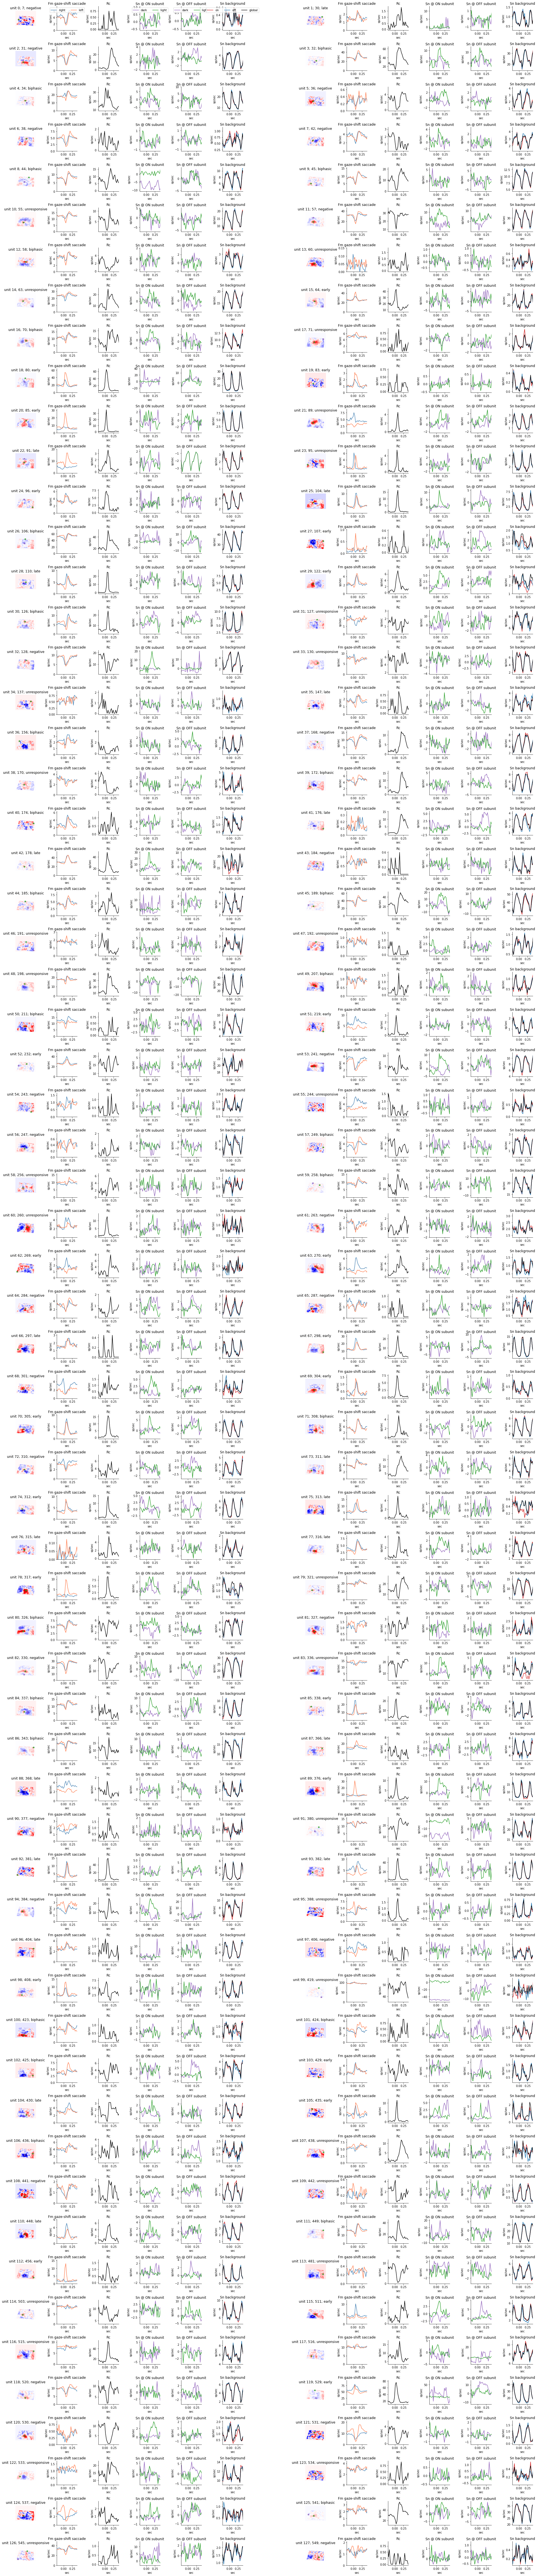

In [75]:
has_RF = range(128)
fig, ax = plt.subplots(64,13,figsize=(26,128))
count = 1
for ind, row in hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'][hffm.data['index'].isin(session_indices[has_RF])].iterrows():
    plt.subplot(64,13,count)
    sta_range = np.max(np.abs(row['Wn_spike_triggered_average']))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(row['Wn_spike_triggered_average'], vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.plot(row['Wn_rf_on_cent'][0], row['Wn_rf_on_cent'][1], '*', color='tab:green')
#     plt.annotate('ON', xy=[row['Wn_rf_on_cent'][0], row['Wn_rf_on_cent'][1]], color='tab:green', fontsize=18)
    plt.plot(row['Wn_rf_off_cent'][0], row['Wn_rf_off_cent'][1], '*', color='tab:purple')
#     plt.annotate('OFF', xy=[row['Wn_rf_off_cent'][0], row['Wn_rf_off_cent'][1]], color='tab:green', fontsize=18)
    plt.axis('off')
    plt.title('unit {}; {}; {}'.format(ind-73, row['index'], row['movcluster']))
    count += 1
    
    plt.subplot(64,13,count)
    plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_gaze_shift_dEye'], color=hffm.cmap_sacc[0], label='right')
    plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_gaze_shift_dEye'], color=hffm.cmap_sacc[1], label='left')
    plt.ylim([0, np.max(np.maximum(row['FmLt_rightsacc_avg_gaze_shift_dEye'], row['FmLt_leftsacc_avg_gaze_shift_dEye']))*1.2])
    plt.xlim([-0.2, 0.4])
    plt.ylabel('sp/sec')
    plt.title('Fm gaze-shift saccade')
    plt.xlabel('sec')
    if ind==73:
        plt.legend(loc=9, ncol=2)
    count += 1
    
    plt.subplot(64,13,count)
    plt.plot(hffm.trange_x, row['Rc_psth'], color='k')
    plt.title('Rc')
    plt.xlim([-0.2, 0.4])
    plt.ylabel('sp/sec')
    plt.xlabel('sec')
    count += 1

    plt.subplot(64,13,count)
    plt.plot(hffm.trange_x, row['Sn_on_darkstim_psth'] - row['Sn_on_background_psth'], color='tab:purple', label='dark')
    plt.plot(hffm.trange_x, row['Sn_on_lightstim_psth'] - row['Sn_on_background_psth'], color='tab:green', label='light')
    plt.title('Sn @ ON subunit')
    plt.xlim([-0.2, 0.4])
    plt.ylabel('sp/sec')
    plt.xlabel('sec')
    if ind==73:
        plt.legend(loc=9, ncol=2)
    count += 1
    
    plt.subplot(64,13,count)
    plt.plot(hffm.trange_x, row['Sn_off_darkstim_psth'] - row['Sn_off_background_psth'], color='tab:purple', label='dark')
    plt.plot(hffm.trange_x, row['Sn_off_lightstim_psth'] - row['Sn_off_background_psth'], color='tab:green', label='light')
    plt.title('Sn @ OFF subunit')
    plt.xlim([-0.2, 0.4])
    plt.ylabel('sp/sec')
    plt.xlabel('sec')
    if ind==73:
        plt.legend(loc=9, ncol=2)
    count += 1
    
    plt.subplot(64,13,count)
    plt.plot(hffm.trange_x, row['Sn_on_background_psth'], color='tab:red', label='on')
    plt.plot(hffm.trange_x, row['Sn_off_background_psth'], color='tab:blue', label='off')
    plt.plot(hffm.trange_x, row['Sn_on_all_psth'], color='k', label='global')
    plt.title('Sn background')
    plt.xlim([-0.2, 0.4])
    plt.ylabel('sp/sec')
    plt.xlabel('sec')
    if ind==73:
        plt.legend(loc=9, ncol=3)
    
    if count%13 != 0:
        count += 1
        plt.subplot(64,13,count)
        plt.axis('off')
        
    count += 1
    
plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/070921RT_SaccRcSn_responses.pdf')

In [52]:
import src.utils.save as ioh5
glm_data = ioh5.load('/home/niell_lab/data/freely_moving_ephys/RFs/GLM_RFs_070921_RT.h5')
glm_rfs = np.reshape(glm_data['Cell_NN.0.weight'], (108,5,30,40))

In [54]:
glm_data.keys()

dict_keys(['Cell_NN.0.bias', 'Cell_NN.0.weight', 'loss_regcv', 'out_cv', 'pred_cv', 'r2_test', 'tloss_trace_all', 'vloss_trace_all'])

In [13]:
drop_pos = [5,13,19,27,34,41,43,47,49,54,56,69,76,105,109,113,119,120,122,125]
pop_inds = hffm.data['index'][hffm.data['session']=='070921_J553RT_control_Rig2'].to_list()
pop_pos = list(range(128))
glm_pos = [i for i in pop_pos if i not in drop_pos]
pop_ind2pos = dict(zip(pop_inds, pop_pos))
pop2glm = dict(zip(glm_pos, range(108)))

In [14]:
fullpop_useinds = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'].index.values
fullpop_to_phy2 = dict(zip(fullpop_useinds, pop_inds))

In [15]:
def spop2glm(i):
    return pop2glm[pop_ind2pos[i]]

In [16]:
def fullpop2glm(i):
    return pop2glm[pop_ind2pos[fullpop_to_phy2[i]]]

In [66]:
flow_dir = np.zeros([108,40,60])
raw_rfs = np.zeros([108,40,60])
full_flow_dir = np.zeros([108,40,60])
on_subunits = np.zeros([108,40,60])
flow_props = np.zeros([108,2])
flow_thresh = np.zeros([108,40,60,2])
for ind, row in hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'].iterrows():
    try:
        glmind = fullpop2glm(ind)
    except KeyError:
        continue
    # get RF for this unit, upsample by 2, and crop edges to match optic flow
    glm_rf = glm_rfs[glmind,2,:,:].repeat(2,axis=0).repeat(2,axis=1)[10:-10,10:-10]
    sta_range = np.max(np.abs(glm_rf))*1.2
    # threshold RF to get on region
    rf_on = glm_rf.copy()
    rf_on[rf_on<(sta_range/2)] = 0
    # threshold flow vector using on region
    fv = row['FmLt_optic_flow_running_forward_vec'].astype(float) # shape is [x, y, U/V]
    thresh_fv = fv.copy()
    thresh_fv[rf_on==0] = np.nan
    # get angle in deg of flow direction
    full_fd_deg = -np.rad2deg(np.arctan2(fv[:,:,1], fv[:,:,0]))%360
    fd_deg = -np.rad2deg(np.arctan2(thresh_fv[:,:,1], thresh_fv[:,:,0]))%360
    raw_rfs[glmind,:,:] = glm_rf.copy()
    on_subunits[glmind,:,:] = rf_on.copy()
    flow_thresh[glmind,:,:,:] = thresh_fv.copy()
    flow_dir[glmind,:,:] = fd_deg.copy()
    full_flow_dir[glmind,:,:] = full_fd_deg.copy()
    flow_props[glmind,0] = np.nanmedian(fd_deg)
    flow_props[glmind,1] = np.nanstd(fd_deg)

In [36]:
sind2popind = dict(zip(hffm.data['index'][hffm.data['session']=='070921_J553RT_control_Rig2'], hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'].index.values))

In [56]:
# sind = 122
glmi = 52 # spop2glm(sind)
pind = sind2popind[sind]

In [60]:
glm_pos[52]

63

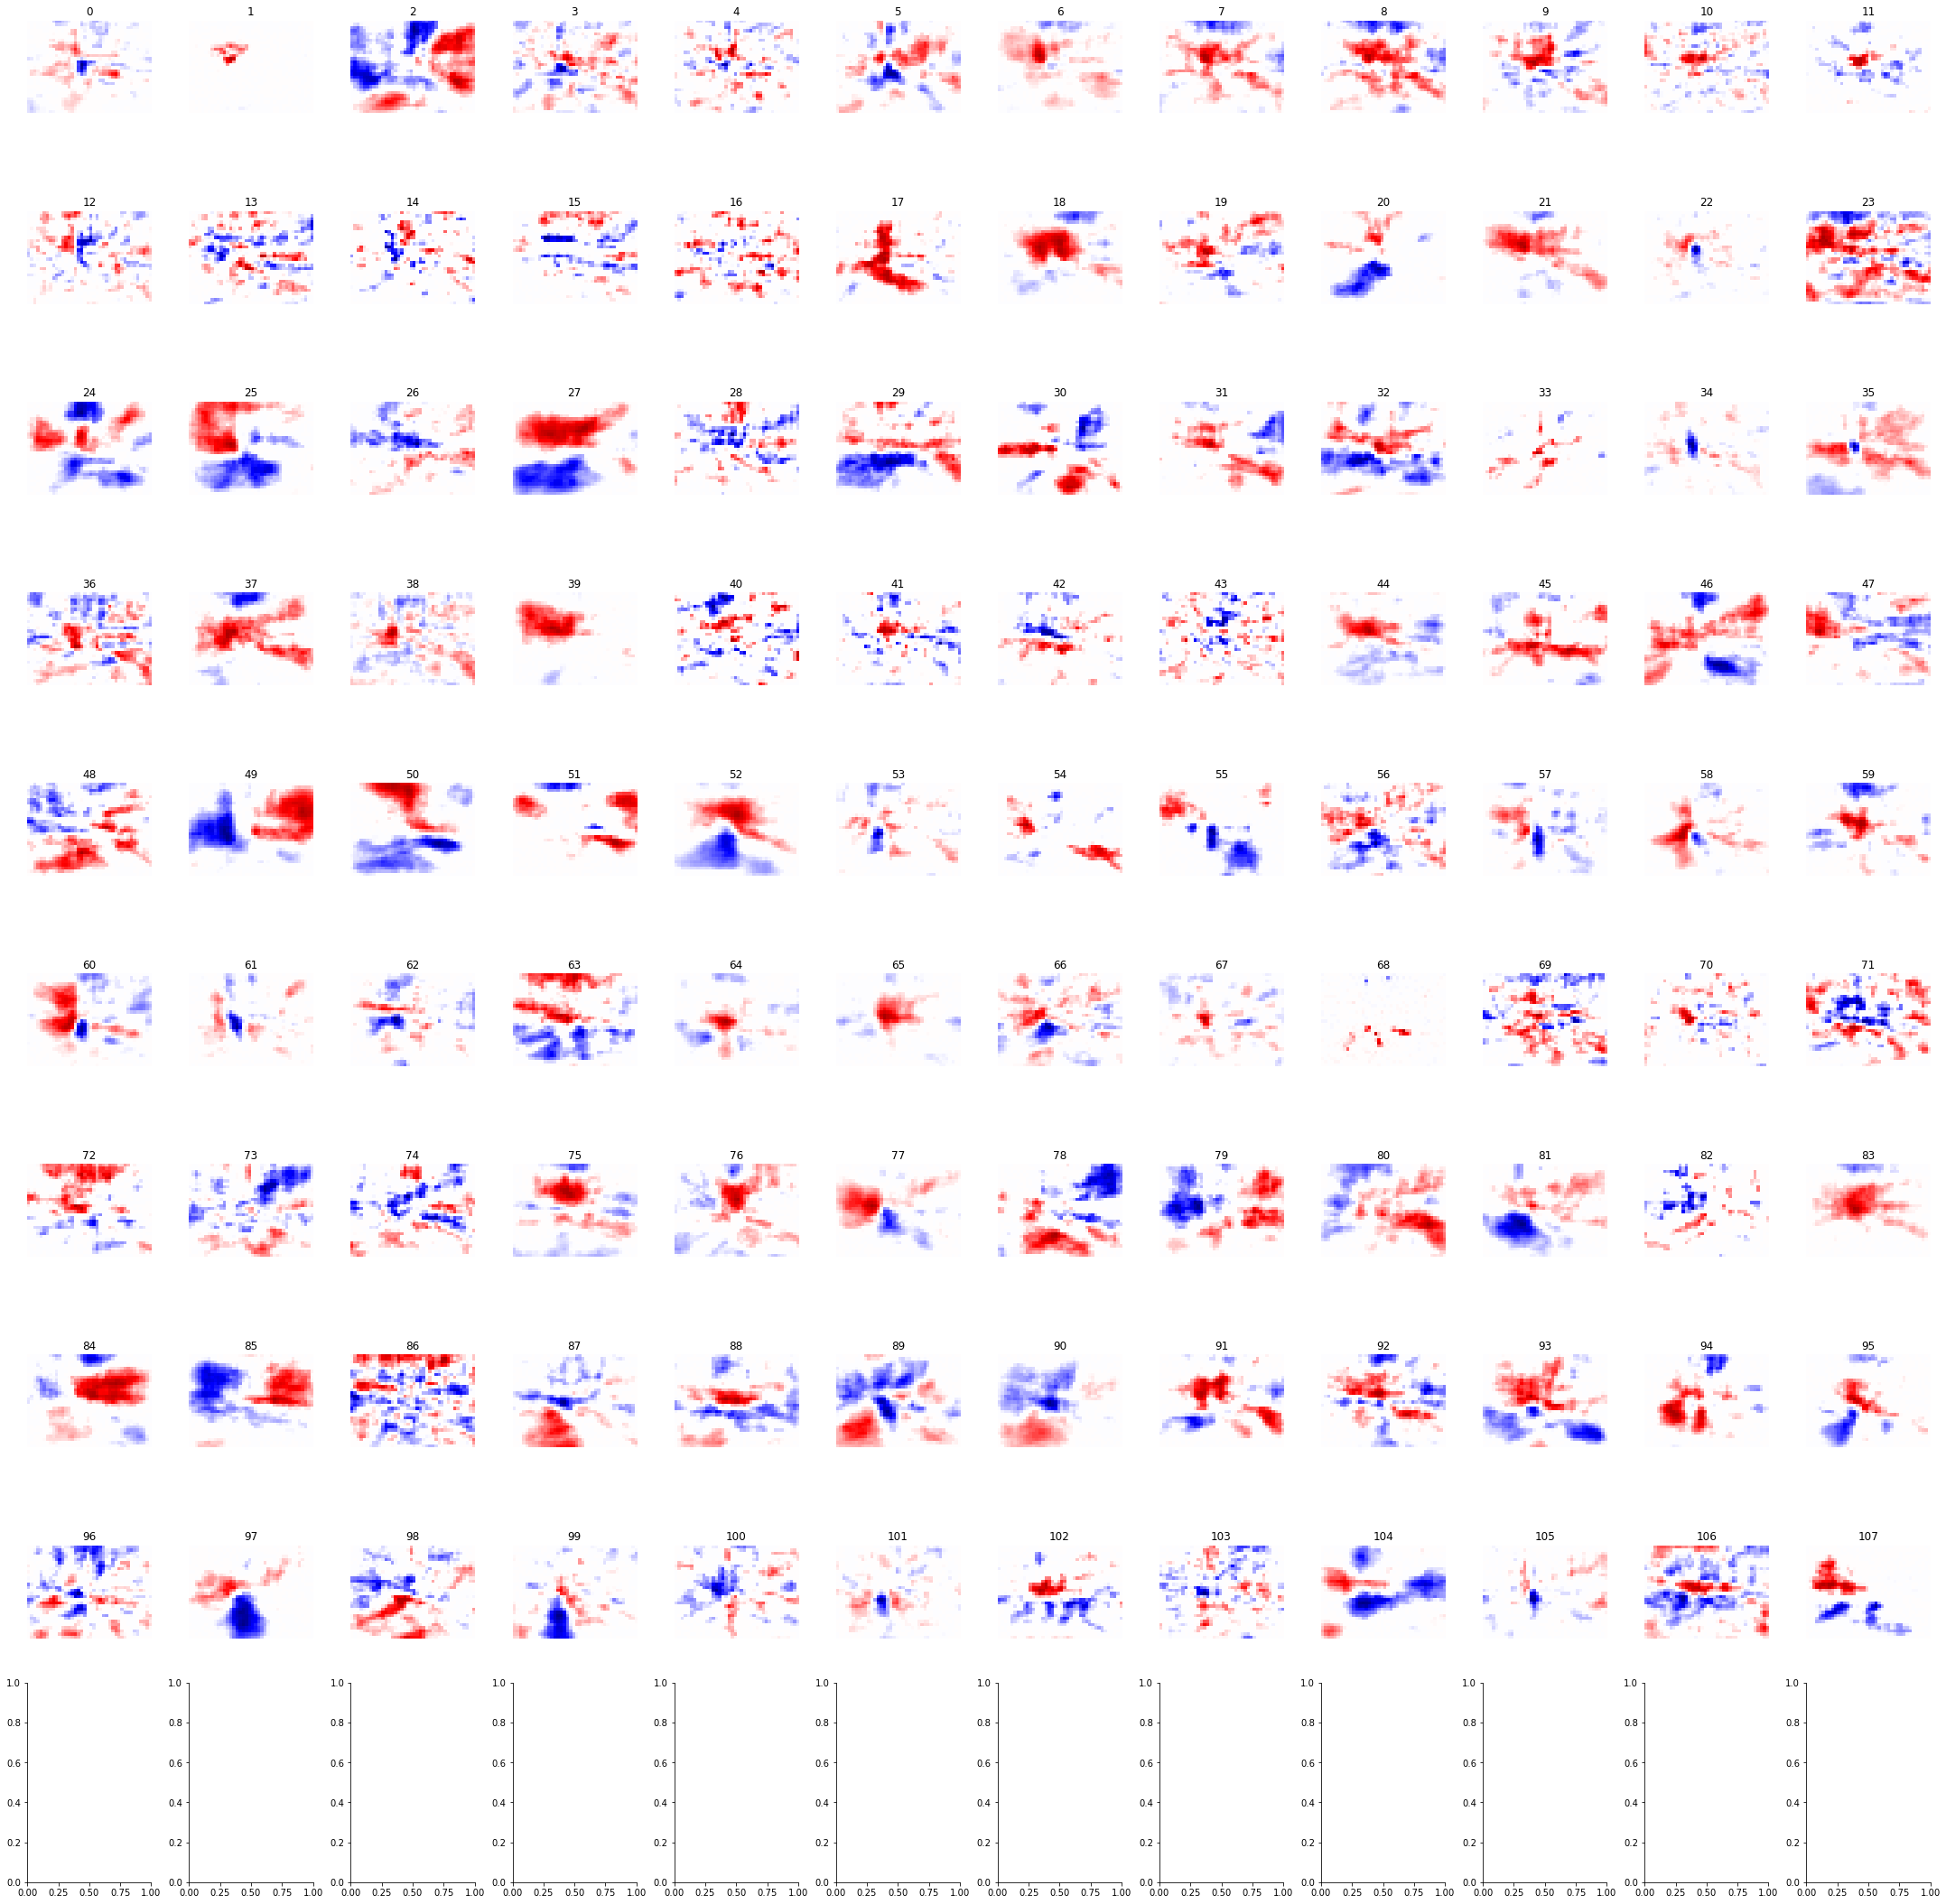

In [55]:
plt.subplots(10,12,figsize=(30,30))
for i in range(108):
    plt.subplot(10,12,i+1)
    plt.title(i)
    plt.axis('off')
    sta_range = np.max(np.abs(glm_rfs[i,2]))*1.2
    plt.imshow(glm_rfs[i,2], vmin=-sta_range, vmax=sta_range, cmap='seismic')
plt.tight_layout()

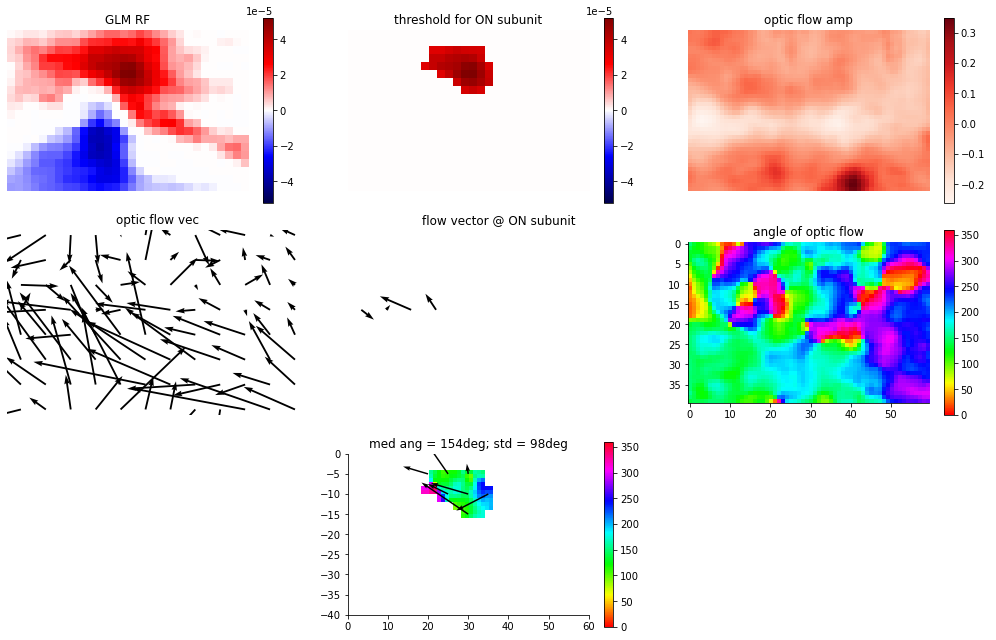

In [69]:
row = hffm.data.iloc[pind].copy()
fig = plt.subplots(3,3,figsize=(14,9))

### STA
ax_sta = plt.subplot(3,3,1)
sta_range = np.max(np.abs(raw_sta))*1.2
# sta_range = (0.25 if sta_range<0.25 else sta_range)
sta_img = ax_sta.imshow(raw_rfs[glmi,:,:], vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_sta.axis('off')
ax_sta.set_title('GLM RF')
plt.colorbar(sta_img, ax=ax_sta)

### thresholded STA
ax_thresh_sta = plt.subplot(3,3,2)
thresh_sta = on_subunits[glmi]
thresh_sta_img = ax_thresh_sta.imshow(thresh_sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_thresh_sta.axis('off')
plt.colorbar(thresh_sta_img, ax=ax_thresh_sta)
ax_thresh_sta.set_title('threshold for ON subunit')

### optic flow amp
ax_amp = plt.subplot(3,3,3)
amp_img = ax_amp.imshow(row['FmLt_optic_flow_running_forward_amp'].astype(float), cmap='Reds')
ax_amp.axis('off')
plt.colorbar(amp_img, ax=ax_amp)
ax_amp.set_title('optic flow amp')

### raw flow vector
ax_vec = plt.subplot(3,3,4)
plot_flow_vec(ax_vec, 'running_forward', row)
ax_vec.set_title('optic flow vec')

### thresholded flow vector
ax_vec_at_RF = plt.subplot(3,3,5)
fv = flow_thresh[glmi].copy()
nx = 5
fv_scale = row['FmLt_flowvec_scale']
flow_w = np.size(thresh_fv, 1)
flow_h = np.size(thresh_fv, 0)
X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
U = thresh_fv[:,:,0]; V = thresh_fv[:,:,1]
ax_vec_at_RF.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)
ax_vec_at_RF.axis('off')
ax_vec_at_RF.axis('equal')
ax_vec_at_RF.set_title('flow vector @ ON subunit')

ax_full_fd = plt.subplot(3,3,6)
img = ax_full_fd.imshow(full_flow_dir[glmi,:,:], cmap='hsv', vmin=0, vmax=360)
ax_full_fd.set_title('angle of optic flow')
plt.colorbar(img, ax=ax_full_fd)

ax = plt.subplot(3,3,7)
ax.axis('off')

### flow direction @ RF
ax_fd = plt.subplot(3,3,8)
img = ax_fd.imshow(flow_dir[glmi,:,:], cmap='hsv', extent=[0,60,-40,0], vmin=0, vmax=360)
ax_fd.set_title('med ang = {:.0f}deg; std = {:.0f}deg'.format(flow_props[i,0], flow_props[i,1]))
plt.colorbar(img, ax=ax_fd)

fv = flow_thresh[glmi,:,:,:].copy()
fv[fv==np.nan] = 0
nx = 5
fv_scale = row['FmLt_flowvec_scale']
flow_w = np.size(fv, 1)
flow_h = np.size(fv, 0)
X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
U = fv[:,:,0]; V = fv[:,:,1]
ax_fd.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)

ax1 = plt.subplot(3,3,9)
ax1.axis('off')

plt.tight_layout()

array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200])

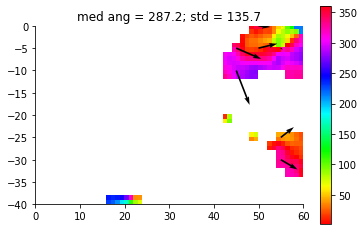

In [27]:
i = 2
ind = i+73

spop2glm


plt.imshow(flow_dir[i,:,:], cmap='hsv', extent=[0,60,-40,0])
plt.title('med ang = {:.1f}; std = {:.1f}'.format(flow_props[i,0], flow_props[i,1]))
plt.colorbar()

fv = flow_thresh[i,:,:,:].copy()
fv[fv==np.nan] = 0
nx = 5
fv_scale = row['FmLt_flowvec_scale']
flow_w = np.size(fv, 1)
flow_h = np.size(fv, 0)
X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
U = fv[:,:,0]; V = fv[:,:,1]
plt.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)

(0.0, 1.0, 0.0, 1.0)

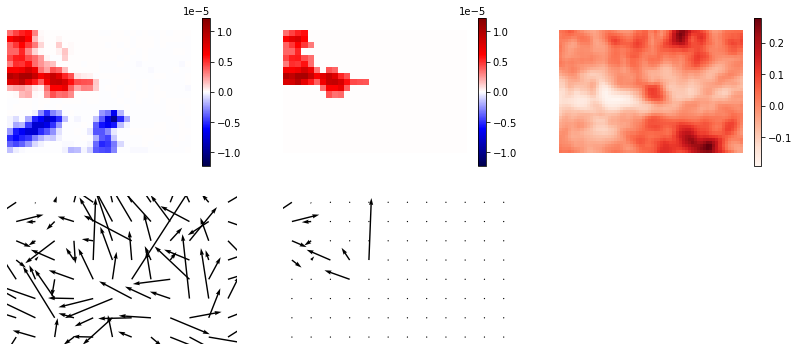

In [87]:
fig = plt.subplots(2,3,figsize=(14,6))

ax_sta = plt.subplot(2,3,1)

raw_sta = glm_rf.copy()
sta_range = np.max(np.abs(raw_sta))*1.2
# sta_range = (0.25 if sta_range<0.25 else sta_range)

sta_img = ax_sta.imshow(raw_sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_sta.axis('off')
plt.colorbar(sta_img, ax=ax_sta)

###
ax_thresh_sta = plt.subplot(2,3,2)

thresh_sta = raw_sta.copy()
thresh_sta[thresh_sta<(sta_range/4)] = 0

thresh_sta_img = ax_thresh_sta.imshow(thresh_sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_thresh_sta.axis('off')
plt.colorbar(thresh_sta_img, ax=ax_thresh_sta)

###
ax_amp = plt.subplot(2,3,3)
amp_img = ax_amp.imshow(row['FmLt_optic_flow_running_forward_amp'].astype(float), cmap='Reds')
ax_amp.axis('off')
plt.colorbar(amp_img, ax=ax_amp)

###
ax_vec = plt.subplot(2,3,4)
plot_flow_vec(ax_vec, 'running_forward', row)

###
ax_vec_at_RF = plt.subplot(2,3,5)

fv = row['FmLt_optic_flow_running_forward_vec'].astype(float) # shape is [x, y, U/V]
thresh_fv = fv.copy()
thresh_fv[thresh_sta==0] = 0

nx = 5
fv_scale = row['FmLt_flowvec_scale']
flow_w = np.size(thresh_fv, 1)
flow_h = np.size(thresh_fv, 0)

X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
U = thresh_fv[:,:,0]; V = thresh_fv[:,:,1]

ax_vec_at_RF.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)
ax_vec_at_RF.axis('off')
ax_vec_at_RF.axis('equal')

###
ax_fd = plt.subplot(2,3,6)

ax_fd.axis('off')

In [ ]:
fd_deg = -np.rad2deg(np.arctan2(thresh_fv[:,:,1], thresh_fv[:,:,0]))%360
fd_deg[fd_deg==0] = np.nan
fd_deg_std = np.nanstd(fd_deg)
fd_deg_mean = np.nanmean(fd_deg)

In [ ]:
fd_deg.shape

In [ ]:
fd_deg_mean

In [ ]:
fd_deg_std

In [ ]:
plt.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)

In [ ]:
plt.imshow(fv[:,:,0])

In [ ]:
fd_deg

In [ ]:
ax = plt.subplot(111)
img = ax.imshow((-np.rad2deg(np.arctan2(fv[:,:,1], fv[:,:,0]))%360), cmap='hsv', extent=[0,60,-40,0])
plt.colorbar(img, ax=ax)
fv = row['FmLt_optic_flow_running_forward_vec'].astype(float) # shape is [x, y, U/V]
nx = 5
fv_scale = row['FmLt_flowvec_scale']
flow_w = np.size(fv, 1)
flow_h = np.size(fv, 0)
X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
U = fv[:,:,0]; V = fv[:,:,1]
ax.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)

In [ ]:
np.sin() # u
np.cos() # v